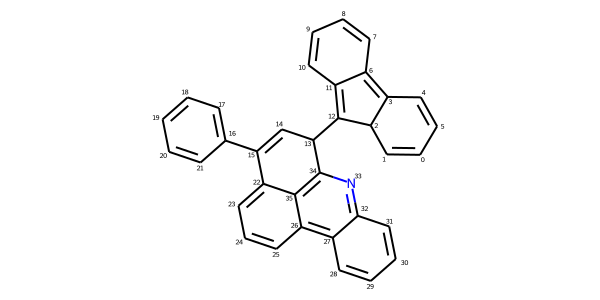

In [60]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('C1=CC2C(C=C1)=c1ccccc1=C2C1C=C(c2ccccc2)c2cccc3c4ccccc4nc1c23')
n = Chem.MolFromSmiles('CCC1=C2C=CC=CC2=C3C1C=CC=C3C')
m

In [61]:
# the cook book example
def GetRingSystems(mol, includeSpiro=False):
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

(max(GetRingSystems(m), key=len))

{13, 14, 15, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35}

In [124]:
def get_adjacent(molecule, includeSpiro=False):
    # Get the ring systems in the molecule
    ring_info = molecule.GetRingInfo()

    # Get biggest ring
    systems = []
    for ring in ring_info.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    max_ring = max(systems, key=len)

    # Now the adjancent
    max_ring_with_adjancent = set(max_ring)
    
    for ring_atom in max_ring:
        neighbors = set(molecule.GetAtomWithIdx(ring_atom).GetNeighbors())
        for neighbor_atom in neighbors:
            max_ring_with_adjancent.add(neighbor_atom.GetIdx())
            # print(f"{ring_atom} (neighbors): {neighbor_atom.GetIdx()}")
    
    kekulized_mol = Chem.MolFromSmiles(Chem.MolFragment(m, max_ring_with_adjancent, kekuleSmiles=True))
    canonical_smiles = Chem.MolToSmiles(kekulized_mol)

    return canonical_smiles


biggest_fragment = (get_adjacent(n))
biggest_fragment


'C=CCC1=c2ccccc2=C(C=C)C1C'

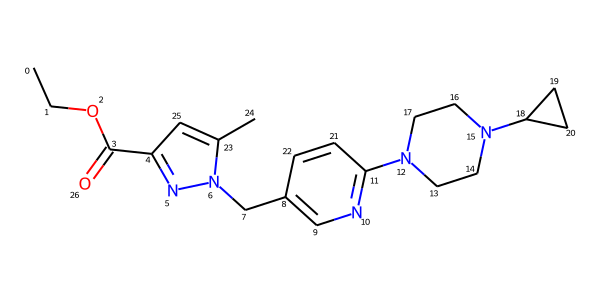

In [12]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True
psmi = 'CCOC(c5nn(Cc6cnc(N7CCN(CC7)C8CC8)cc6)c(C)c5)=O'
mol = Chem.MolFromSmiles(psmi)
mol

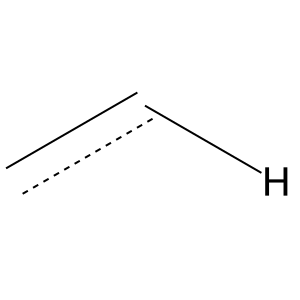

In [26]:
from rdkit import Chem

# Step 2: Create a new molecule
new_molecule = Chem.RWMol()

# Step 3: Add atoms
atom1 = new_molecule.AddAtom(Chem.Atom(6))  # Atom with atomic number 6 (Carbon)
atom2 = new_molecule.AddAtom(Chem.Atom(1))  # Atom with atomic number 1 (Hydrogen)
atom3= new_molecule.AddAtom(Chem.Atom(6))

# Step 4: Add a bond
bond_type = Chem.BondType.SINGLE  # You can choose bond type (SINGLE, DOUBLE, TRIPLE)
new_molecule.AddBond(atom1, atom2, bond_type)
new_molecule.AddBond(atom1, atom3, Chem.BondType.AROMATIC)

# Optional: If you want to visualize the molecule (requires RDKit and matplotlib)
from rdkit.Chem import Draw
Draw.MolToImage(new_molecule)
